<h1> Indian Metal Coins Classification </h1>

In [ ]:
#check if we have GPU available
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Oct 30 09:50:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Extract dataset Zip file

In [ ]:
#Define path variable for dataset zip file 
DATASET_ZIPFILE = "/content/drive/MyDrive/currency/indian_coins_dataset.zip"

In [ ]:
#unzip the files
import zipfile
import os
import time


#create Data dir in cwd
if os.path.exists('data'):
  pass
else :
  !mkdir 'data'

#create zipfile instance
zip_ref = zipfile.ZipFile(DATASET_ZIPFILE, 'r')


start = time.time()
print('Dataset zipfile Extract in progress..')

zip_ref.extractall('data')
zip_ref.close()

end = time.time()
duration = end - start
print ('\n Unzipping took took %0.2f seconds (%0.1f minutes) to complete'%(duration, duration/60) )

print("\n")
!ls 'data'


Dataset zipfile Extract in progress..

 Unzipping took took 58.87 seconds (1.0 minutes) to complete


indian_coins_dataset


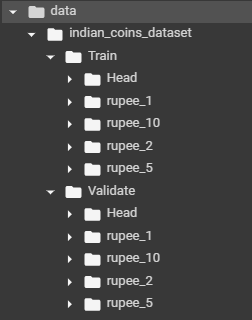

In [ ]:
#define Variables
DATA_DIR = "/content/data/indian_coins_dataset"
TRAINING_DIR = "/content/data/indian_coins_dataset/Train"
VALIDATION_DIR = "/content/data/indian_coins_dataset/Validate"

In [ ]:
#make dir in current working dir to store few generated outputs during training process
!mkdir output 

#define output variable
OUTPUT_DIR = '/content/output'

!cd '/content/output'
!pwd

!mkdir '/content/output/plots'
!mkdir '/content/output/models'

/content


## Required Libraries

In [ ]:
#pandas for dataframe manipulation
import pandas as pd
#mathimetical operations
import numpy as np

#visualization 
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
from PIL import Image

# importing necessary libraries for Data Augmentation
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

# importing nexessary libraries for Modeling a CNN
import tensorflow.keras as keras

# different layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalMaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,load_model,Model

from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2


# for callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

# Optimiser
from tensorflow.keras.optimizers import Adam


# Explore Dataset 

In [ ]:
print("Directories Available : ",os.listdir(DATA_DIR),'\n')

classes = os.listdir(TRAINING_DIR)
NUM_CLASSES = len(classes)
print("Number of classes in Train set : ",NUM_CLASSES,'\nClasses',classes,'\n')

count_train={}
total_train = 0

#train dataset
for i in range(len(classes)):
    c = len(os.listdir(os.path.join(TRAINING_DIR,classes[i])))
    count_train[i]=c
    print("Class ",classes[i]," : ",count_train[i])
    total_train += count_train[i]
print("Total images in Train set for all classes : ",total_train,'\n')

count_test={}
total_test = 0

#test dataset
print("Number of classes in Validation set : ",len(os.listdir(VALIDATION_DIR))) 

for i in range(len(classes)):
    c = len(os.listdir(os.path.join(VALIDATION_DIR,classes[i])))
    count_test[i]=c
    print("Class ",classes[i]," : ",count_test[i])
    total_test += count_test[i]
print("Total images in Validation set for all classes : ",total_test,'\n')


Directories Available :  ['Validate', 'Train'] 

Number of classes in Train set :  5 
Classes ['Head', 'rupee_10', 'rupee_5', 'rupee_2', 'rupee_1'] 

Class  Head  :  257
Class  rupee_10  :  123
Class  rupee_5  :  193
Class  rupee_2  :  205
Class  rupee_1  :  231
Total images in Train set for all classes :  1009 

Number of classes in Validation set :  5
Class  Head  :  25
Class  rupee_10  :  6
Class  rupee_5  :  13
Class  rupee_2  :  22
Class  rupee_1  :  13
Total images in Validation set for all classes :  79 



So , We have 4 classes of Indian coins. Dataset available is small which will impact model performance and can be improved to some extent via Data Augmentation before training the model.<br><br>

Let's now check how the dataset images looks like ..

## Visualizations

### Class frequency distribution

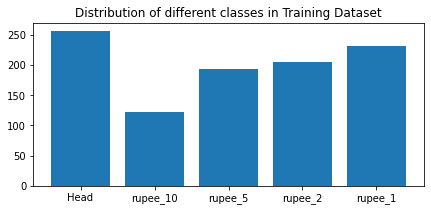

In [ ]:
# plotting a bargraph for train data
plt.figure(figsize=(7,3))
plt.bar(range(len(count_train)), list(count_train.values()), align='center')
plt.xticks(range(len(count_train)),classes)
plt.title('Distribution of different classes in Training Dataset')
plt.show()

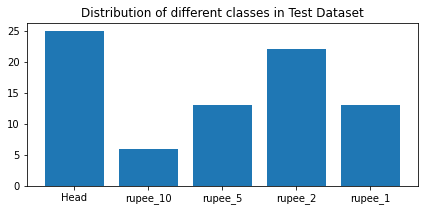

In [ ]:
# plotting a bargraph for test data
plt.figure(figsize=(7,3))
plt.bar(range(len(count_test)), list(count_test.values()), align='center')
plt.xticks(range(len(count_test)), classes)
plt.title('Distribution of different classes in Test Dataset')
plt.show()

So , We have imbalance dataset 

### Plot sample images from each class

In [ ]:
coins_list = [0,1,2,5,10]

In [ ]:
images_files = []
for i in range(len(coins_list)):
    for j in range(5):
      if coins_list[i] == 0:
        f = os.listdir(os.path.join(TRAINING_DIR+'/Head'))[j]
        images_files.append(os.path.join(TRAINING_DIR+'/Head/'+f))
      else :
        f = os.listdir(os.path.join(TRAINING_DIR+'/rupee_'+str(coins_list[-i])))[j]
        images_files.append(os.path.join(TRAINING_DIR+'/rupee_'+str(coins_list[-i])+'/'+f))
    

In [ ]:
#len(images_files)
#images_files

25

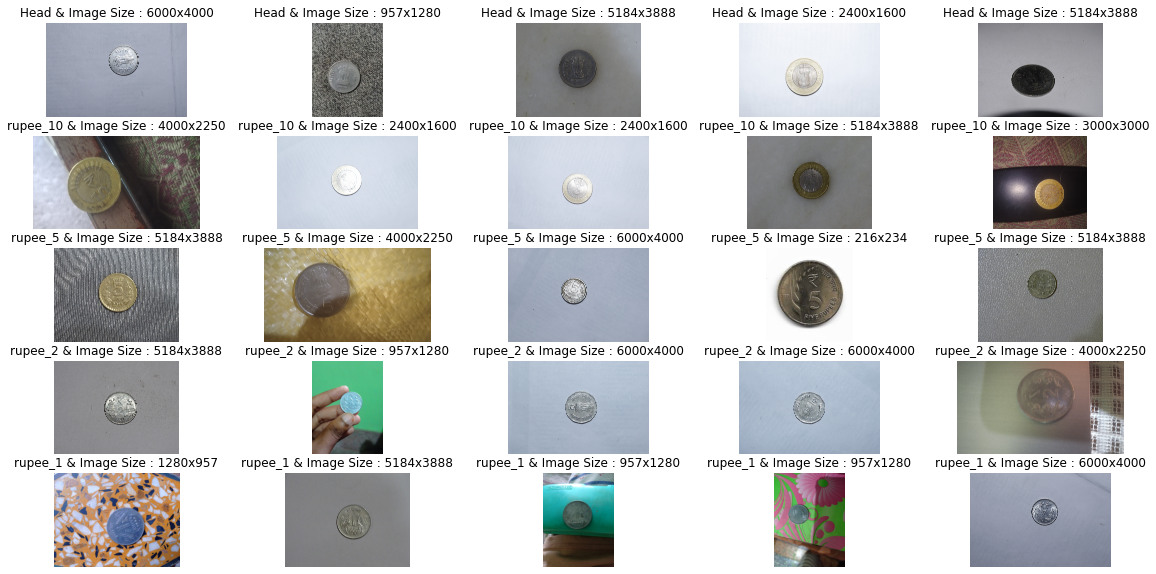

In [ ]:
#plot sample image for each class and image size

plt.figure(1, figsize=(20,10))
plt.axis('off')
n = 0
for i in range(len(images_files)):
    n += 1
    #random_img = random.choice(images)
    imgs = imread(images_files[i])
    plt.subplot(5,5, n)
    plt.axis('off')

    im = Image.open(images_files[i])
    w, h = im.size
    img_size = str(w)+'x'+str(h)


    plt.title(os.path.dirname(images_files[i]).split("/")[-1] + " & Image Size : "+img_size)
    plt.imshow(imgs)
    
plt.show()

Images looks to be similar, due to less focus on coins and we have more of white or backgroud noise. 
<br>The backside(head) of coin looks to be similar for coin of rupee 1 and rupee 2 . 
<br>Color of coin of rupee 5 and rupee 10 looks to be some what similar. This features can confuse the model.

# **Data Augmentation**


Data augmentation is used to increase the size of training set and to get more different image. Through Data augmentation we can prevent overfitting ,this refers to randomly changing the images in ways that shouldn’t impact their interpretation, such as horizontal flipping, zooming, and rotating.

Below image shows transformation on the original image


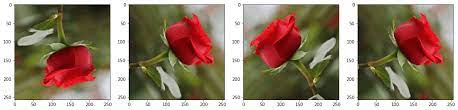

Since We have less number of images , Augumentation would increase size of dataset on fly and help get more accurate results

In [ ]:
def get_datagenerators(TRAINING_DIR,VALIDATION_DIR,IMAGE_SIZE,BATCH_SIZE):
  
    #train and validation dataGenerator 
    train_datagen = ImageDataGenerator( rescale = 1./255, #rescaling factor
                                      rotation_range = 40, #rotates the images by 40 deg
                                      horizontal_flip = True,
                                      fill_mode = 'nearest', # Points to the nearest image
                                      zoom_range = 0.3, #Zoom images 
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.3,
                                      shear_range = 0.2) # Range for shear angle in counter-clockwise direction in degrees


    validation_datagen = ImageDataGenerator(rescale = 1./255,
                                      horizontal_flip = True,
                                      rotation_range = 40, #rotates the images by 40 deg
                                      fill_mode = 'nearest',
                                      zoom_range = 0.3,
                                      width_shift_range = 0.3,
                                      height_shift_range = 0.3,
                                      shear_range = 0.2) # Range for shear angle in counter-clockwise direction in degrees


    train_generator = train_datagen.flow_from_directory(
      TRAINING_DIR,
      target_size = (IMAGE_SIZE,IMAGE_SIZE),
      class_mode= 'categorical',
      batch_size=BATCH_SIZE
    )

    validation_generator = validation_datagen.flow_from_directory(
      VALIDATION_DIR,
      target_size = (IMAGE_SIZE,IMAGE_SIZE),
      class_mode='categorical',
      batch_size=BATCH_SIZE
    )

    return train_generator, validation_generator

# Model Training

In [ ]:
keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications.xception import Xception


model = Xception(include_top = False,
              weights = 'imagenet',
              input_tensor = None,
              input_shape = (300,300, 3))


for layer in model.layers[:8]:
  layer.trainable = False

for layer in model.layers[8:]:
  layer.trainable = True

x = model.output
x = GlobalMaxPooling2D()(x)
x = Flatten()(x)


#output layer
predictions = Dense(5, activation="softmax")(x)

# creating the final model 
model_final = Model(inputs = model.input, outputs = predictions)



model_final.compile(optimizer=Adam(learning_rate=0.0002), # one of the best optimisers
              loss='categorical_crossentropy', 
              metrics = ['accuracy']) # performance metrics used

#print model summary               
model_final.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [ ]:
#get callback list 
callback_list = get_callbacks_list("Xception_bestWeights.hdf5")

#train model
Xception_history = model_final.fit(train_generator,
                epochs=25,
                batch_size=16,
                validation_data=validation_generator,
                callbacks=callback_list,
                verbose=1)

Epoch 1/25
64/64 [==============================] - 187s 3s/step - loss: 1.1177 - accuracy: 0.5669 - val_loss: 2.3168 - val_accuracy: 0.4810

Epoch 00001: val_accuracy improved from -inf to 0.48101, saving model to /content/output/models/Xception_bestWeights.hdf5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/25
64/64 [==============================] - 179s 3s/step - loss: 0.4881 - accuracy: 0.8127 - val_loss: 2.0524 - val_accuracy: 0.5570

Epoch 00002: val_accuracy improved from 0.48101 to 0.55696, saving model to /content/output/models/Xception_bestWeights.hdf5
Epoch 3/25
64/64 [==============================] - 179s 3s/step - loss: 0.3342 - accuracy: 0.8870 - val_loss: 1.6109 - val_accuracy: 0.7342

Epoch 00003: val_accuracy improved from 0.55696 to 0.73418, saving model to /content/output/models/Xception_bestWeights.hdf5
Epoch 4/25
64/64 [==============================] - 179s 3s/step - loss: 0.2431 - accuracy: 0.9267 - val_loss: 1.2746 - val_accuracy: 0.7722

Epoch 00004: val_accuracy improved from 0.73418 to 0.77215, saving model to /content/output/models/Xception_bestWeights.hdf5
Epoch 5/25
64/64 [==============================] - 180s 3s/step - loss: 0.1704 - accuracy: 0.9405 - val_loss: 1.8877 - val_accuracy: 0.5823

Epoch 00005: val_accuracy did not improve from 0.77215
Ep

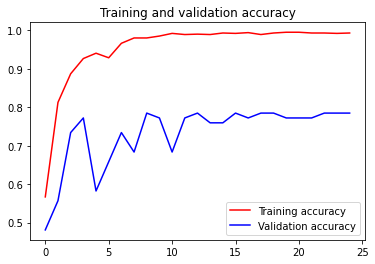

<Figure size 432x288 with 0 Axes>

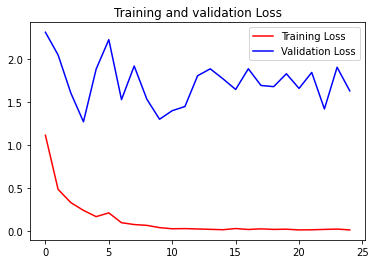

<Figure size 432x288 with 0 Axes>

In [ ]:
#plot model performance history

acc = Xception_history.history['accuracy']
val_acc = Xception_history.history['val_accuracy']
loss = Xception_history.history['loss']
val_loss = Xception_history.history['val_loss']

epochs = range(len(acc))

#plot accuracy 
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure();
plt.show()

#plot loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
train_generator.class_indices

{'Head': 0, 'rupee_1': 1, 'rupee_10': 2, 'rupee_2': 3, 'rupee_5': 4}

In [ ]:
model_final.evaluate(validation_generator)

5/5 [==============================] - 23s 5s/step - loss: 1.5808 - accuracy: 0.7722


[1.5807632207870483, 0.7721518874168396]

# Test Model on unseen data

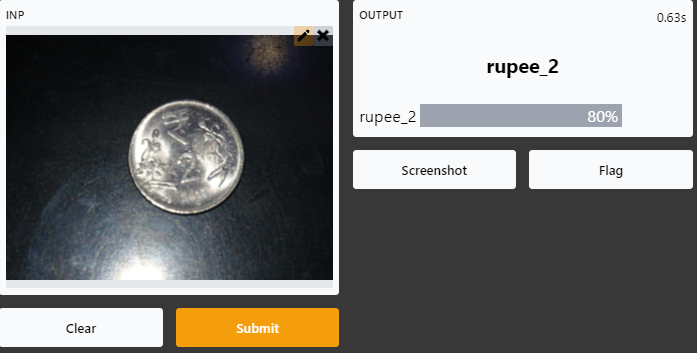

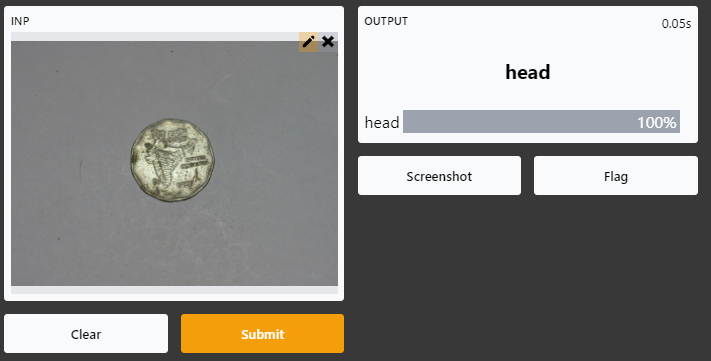

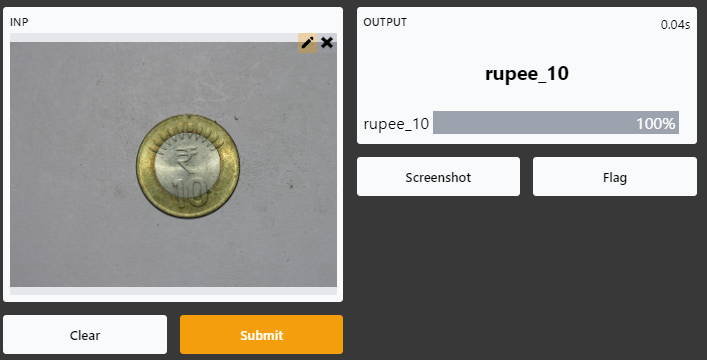

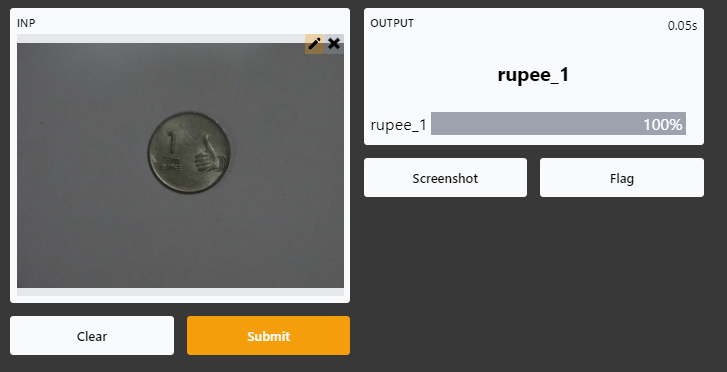

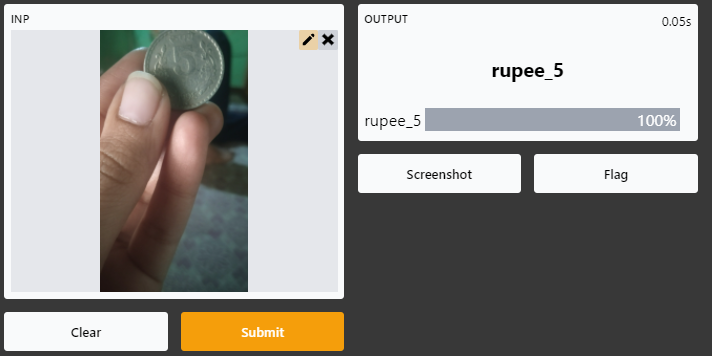

# Save Model to diffenent file formats

In [ ]:
#h5
model_final.save('Metal_currency_classification.h5')

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
#hdf5
model_final.save("m.hdf5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
